# Concept discovery on MNIST

In [2]:
import sys
sys.path.append('..')
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sympy import simplify_logic
import time
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import _tree, export_text
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import seaborn as sns

import lens
from lens.utils.base import validate_network, set_seed, tree_to_formula
from lens.utils.layer import prune_logic_layers
from lens import logic

results_dir = 'results_ll/mnist_h'
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

models_dir = 'models_ll/mnist_h'
if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

## Load MNIST data

In [4]:
# MNIST problem
num_workers = 0
batch_size = 256
valid_size = 0.2
# Data augmentation for train data + conversion to tensor
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])  # Data augmentation for test data + conversion to tensor
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)

## Generate data loaders

In [5]:
# Finding indices for validation set
num_train = len(train_data)
indices = list(range(num_train))
# Randomize indices
np.random.shuffle(indices)
split = int(np.floor(num_train * valid_size))
train_index, test_index = indices[split:], indices[:split]  # Making samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(test_index)  # Creating data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# Model
## Define CNN architecture

In [11]:
n_concepts = 16

In [12]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = torch.nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(8, n_concepts, 3, padding=1)
        self.log1 = lens.nn.XLogicConv2d(in_channels=n_concepts, channel_size=30, activation='leaky_relu')
        self.fc5 = torch.nn.Linear(n_concepts, 8)
        self.fc6 = torch.nn.Linear(8, 2)
        self.log2 = lens.nn.XLogic(2, top=True, activation='leaky_relu')
        # max pooling
        self.pool = torch.nn.MaxPool2d(2, 1, padding=1)
        self.filter_output = None

    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        self.filter_output = x
        x = self.log1(x)
        x = F.leaky_relu(self.fc5(x))
        x = F.leaky_relu(self.fc6(x))
        x = self.log2(x)
        return F.softmax(x, dim=1)

## Train model

### Whitening Loss function

In [24]:
# the target covariance matrix is diagonal
cov_objective = torch.eye(n_concepts).to(device)

def whitening_loss(model):
    loss = 0
    for module in model.children():
        if isinstance(module, lens.nn.XLogicConv2d):
            # compute covariance matrix of activations
            cov = 1 / (n_concepts - 1) * torch.matmul(module.conceptizator.concepts.T, module.conceptizator.concepts)
            loss += torch.norm(cov - cov_objective, p=2)
    return loss, cov

### L1-regularization loss

In [25]:
def l1_loss(model):
    loss = 0
    for module in model.children():
        if isinstance(module, lens.nn.XLogicConv2d):
            loss += torch.norm(module.weight, 1) + torch.norm(module.bias, 1)
    return loss

Current Epoch: 1
Training Loss: 1.020751
Validation Loss: 0.600256
Test Accuracy of class "even": 100.0%
Test Accuracy of class "odd": 75.0%


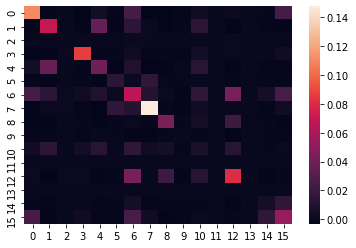

Current Epoch: 2
Training Loss: 0.806578
Validation Loss: 0.490248
Test Accuracy of class "even": 100.0%
Test Accuracy of class "odd": 87.5%


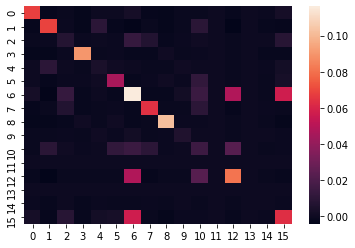

Current Epoch: 3
Training Loss: 0.72567
Validation Loss: 0.454496
Test Accuracy of class "even": 100.0%
Test Accuracy of class "odd": 87.5%


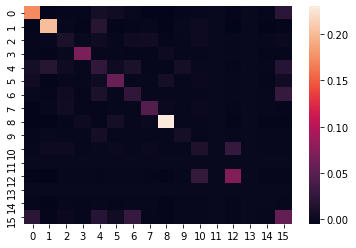

Current Epoch: 4
Training Loss: 0.688664
Validation Loss: 0.436935
Test Accuracy of class "even": 100.0%
Test Accuracy of class "odd": 92.5%


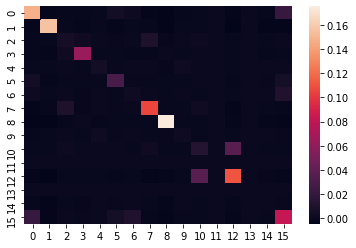

Current Epoch: 5
Training Loss: 0.668615
Validation Loss: 0.421013
Validation loss decreased from inf to 0.421013
Saving New Model
Test Accuracy of class "even": 97.5%
Test Accuracy of class "odd": 95.0%


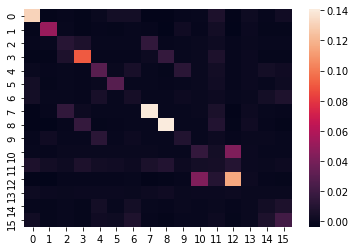

Current Epoch: 6
Training Loss: 0.647474
Validation Loss: 0.407458
Validation loss decreased from 0.421013 to 0.407458
Saving New Model
Test Accuracy of class "even": 100.0%
Test Accuracy of class "odd": 95.0%


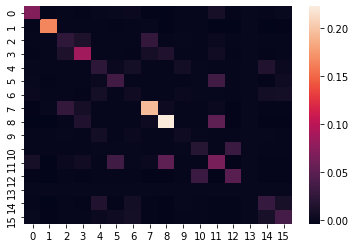

Current Epoch: 7
Training Loss: 0.629364
Validation Loss: 0.403302
Validation loss decreased from 0.407458 to 0.403302
Saving New Model
Test Accuracy of class "even": 97.5%
Test Accuracy of class "odd": 97.5%


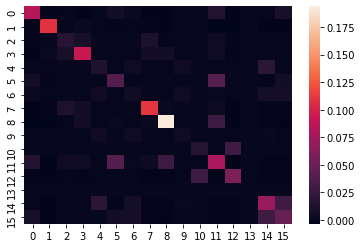

Current Epoch: 8
Training Loss: 0.622717
Validation Loss: 0.392979
Validation loss decreased from 0.403302 to 0.392979
Saving New Model
Test Accuracy of class "even": 100.0%
Test Accuracy of class "odd": 95.0%


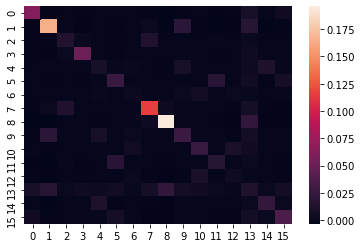

Current Epoch: 9
Training Loss: 0.606715
Validation Loss: 0.383571
Validation loss decreased from 0.392979 to 0.383571
Saving New Model
Test Accuracy of class "even": 100.0%
Test Accuracy of class "odd": 97.5%


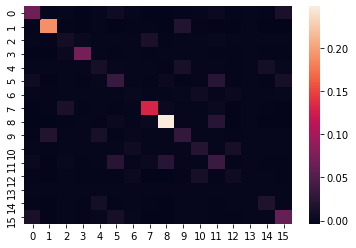

Current Epoch: 10
Training Loss: 0.603144
Validation Loss: 0.376979
Validation loss decreased from 0.383571 to 0.376979
Saving New Model
Test Accuracy of class "even": 100.0%
Test Accuracy of class "odd": 97.5%


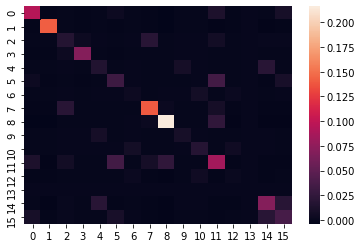

In [28]:
model = Net()
model.cuda()

if os.path.isfile('./models_ll/mnist_h/trained_model_h3.pt'):
    # load trained model
    model.load_state_dict(torch.load('./models_ll/mnist_h/trained_model_h3.pt'))

else:
    epochs = 10
    set_seed(0)
    need_pruning = True

    # tracks validation loss change after each epoch
    minimum_validation_loss = np.inf

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs + 1):

        train_loss = 0
        valid_loss = 0

        # training steps
        model.train()
        for batch_index, (data, target) in enumerate(train_loader):
            # moves tensors to GPU
            data, target = data.cuda(), target.cuda() % 2
            # clears gradients
            optimizer.zero_grad()
            # forward pass
            output = model(data)  # .squeeze()
            # loss in batch
            loss = criterion(output, target) + 0.1 * whitening_loss(model)[0] + 0.001 * l1_loss(model)

            # backward pass for loss gradient
            loss.backward()
            # update paremeters
            optimizer.step()
            # update training loss
            train_loss += loss.item() * data.size(0)

        # validation steps
        model.eval()
        for batch_index, (data, target) in enumerate(valid_loader):
            # moves tensors to GPU
            data, target = data.cuda(), target.cuda() % 2
            # forward pass
            output = model(data)
            # loss in batch
            loss = criterion(output, target)
            # update validation loss
            valid_loss += loss.item() * data.size(0)

        # average loss calculations
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)

        # Display loss statistics
        print(f'Current Epoch: {epoch}\nTraining Loss: {round(train_loss, 6)}\nValidation Loss: {round(valid_loss, 6)}')

        # Saving model every time validation loss decreases
        if valid_loss <= minimum_validation_loss and epoch > 4:
            print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(valid_loss, 6)}')
            torch.save(model.state_dict(), './models_ll/mnist_h/trained_model_h3.pt')
            minimum_validation_loss = valid_loss
            print('Saving New Model')

        # tracking test loss
        test_loss = 0.0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))

        # test steps
        model.eval()
        for batch_index, (data, target) in enumerate(test_loader):
            # moves tensors to GPU
            data, target = data.cuda(), target.cuda() % 2
            # forward pass
            output = model(data)
            # loss in batch
            loss = criterion(output, target)

            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(
                correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            for i in range(2):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

        print(f'Test Accuracy of class "even": {round(100 * class_correct[0] / class_total[0], 2)}%')
        print(f'Test Accuracy of class "odd": {round(100 * class_correct[1] / class_total[1], 2)}%')
        
        cov_np = whitening_loss(model)[1].cpu().detach().numpy()
        plt.figure()
        sns.heatmap(cov_np)
        plt.show()

    model.load_state_dict(torch.load('./models_ll/mnist_h/trained_model_h3.pt'))

# Concepts' visualization

### Feed the network with validation data

In [29]:
model.eval()
x_subset, y_subset, pred_subset = [], [], []
for i, (x_subset_i, y_subset_i) in enumerate(iter(valid_loader)):
    x_subset.append(x_subset_i)
    y_subset.append(y_subset_i)
    pred_subset.append(model.cpu()(x_subset_i))

x_subset = torch.cat(x_subset)
y_subset = torch.cat(y_subset)
pred_subset = torch.cat(pred_subset)

model.cpu()(x_subset)
symbols = model.log1.conceptizator.concepts

### Covariance matrix in the concept layer

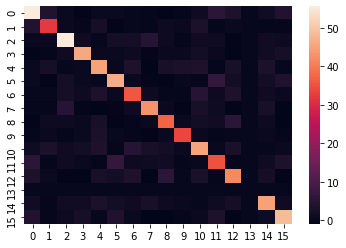

In [34]:
cov_objective = cov_objective.cpu()
cov_np = whitening_loss(model.cpu())[1].cpu().detach().numpy()

plt.figure()
sns.heatmap(cov_np)
plt.show()

## Visualize concepts 

### Concept filters

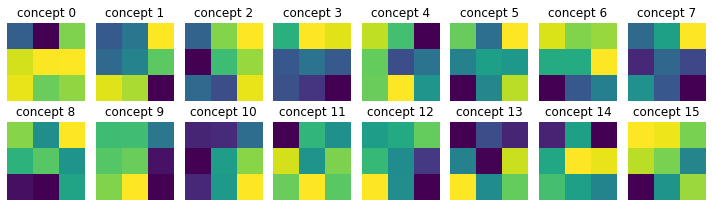

In [36]:
plt.figure(figsize=[10, 3])
max_c = 8
max_r = 2
for i in range(model.conv2.weight.size(0)):
    plt.subplot(max_r, max_c, i + 1)
    plt.title(f'concept {i}')
    plt.imshow(model.conv2.weight[i].sum(dim=0).detach().numpy())
    plt.axis('off')
plt.tight_layout()
plt.savefig('mnist_filters.png')
plt.show()

### Concept embeddings

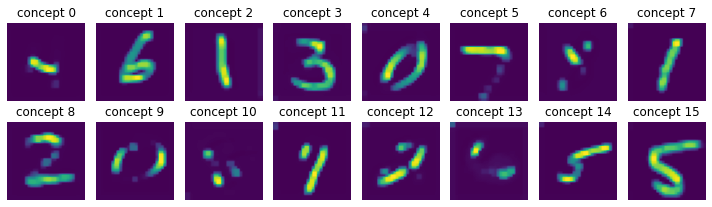

In [40]:
plt.figure(figsize=[10, 3])
max_c = 8
max_r = 2
for q, c in enumerate(torch.topk(symbols.abs(), k=1, dim=0)[1].T):
    plt.subplot(max_r, max_c, q + 1)
    plt.title(f'concept {q}')
    plt.imshow((model.filter_output[c, q] + 1).sum(dim=0).cpu().detach().numpy())
    plt.axis('off')
    if q >= (max_c * max_r - 1): break
plt.tight_layout()
plt.savefig('mnist_filters_output.png')
plt.show()

### Input images associated with concepts

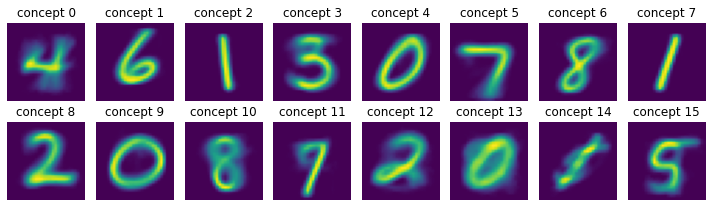

In [41]:
plt.figure(figsize=[10, 3])
max_c = 8
max_r = 2
for q, c in enumerate(torch.topk(symbols.abs(), k=100, dim=0)[1].T):
    plt.subplot(max_r, max_c, q + 1)
    plt.title(f'concept {q}')
    #     plt.imshow((x_subset[c, 0]+1).sum(dim=0).exp())
    plt.imshow((x_subset[c, 0] + 1).sum(dim=0))
    #     plt.figure(figsize=[10,2])
    #     for j, i in enumerate(c):
    #         plt.subplot(1, len(c), j+1)
    #         plt.imshow(x_subset[i, 0])
    plt.axis('off')
    if q >= (max_c * max_r - 1): break
plt.tight_layout()
plt.savefig('mnist_concepts.png')
plt.show()

# FOL formulas

In [42]:
# threshold = 0.

# # positive class
# target_class = 1
# start = time.time()
# class_explanation, class_explanations = logic.explain_class(model.cpu(),
#                                                             x_subset,
#                                                             symbols>threshold,
#                                                             y_subset % 2,
#                                                             target_class=target_class,
#                                                             simplify=True,
#                                                             topk_explanations=5)
# elapsed_time = time.time() - start
# print(class_explanations['layer_5-neuron_1'])
# class_explanation = class_explanations['layer_5-neuron_1']

# # %%

# # # model.eval()
# # # x_subset, y_subset = next(iter(valid_loader))
# pred_subset = model.cpu()(x_subset)
# # # print(class_explanation)
# y_formula = lens.logic.metrics.predictions(class_explanation, target_class,
#                                          model.log1.conceptizator.concepts>threshold,
#                                          y_subset % 2, metric=accuracy_score)
# y_pred = pred_subset[:, 0].detach().cpu().numpy()
# y_true = (y_subset.to(device) % 2 < 0.5).detach().cpu().numpy()
# print(y_formula.shape)
# print(y_pred.shape)
# print(y_true.shape)

# # %%

# # concept_consistency, formula_consistency,
# accuracy_model = accuracy_score(y_pred>0.5, y_true)
# accuracy = accuracy_score(y_formula, y_true)
# fidelity = lens.logic.metrics.fidelity(y_formula>0.5, y_pred>0.5)
# complexity = lens.logic.metrics.complexity(class_explanation)
# print(f'Accuracy: {accuracy}')
# print(f'Fidelity: {fidelity}')
# print(f'Complexity: {complexity}')